# EDA

## data1 (Regression_data)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/Regression_data.csv')
df.info()
df.head()
print(f'\n 중복항 존재여부 : {df.duplicated().any()}\n')
print(df.Sex.value_counts())
# Sex를 제외하곤 전부 수치형데이터 => catboost 고려 x
# Sex 컬럼의 카디널리티 3, 분포는 고른편
# 결측치 없음. 중복 없음
# row 4177개로 비교적 적음. => lightGBM 고려 x
# => 우선적으로 xgboost와 딥러닝중 선택해야할듯?


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB

 중복항 존재여부 : False

M    1528
I    1342
F    1307
Name: Sex, dtype: int64


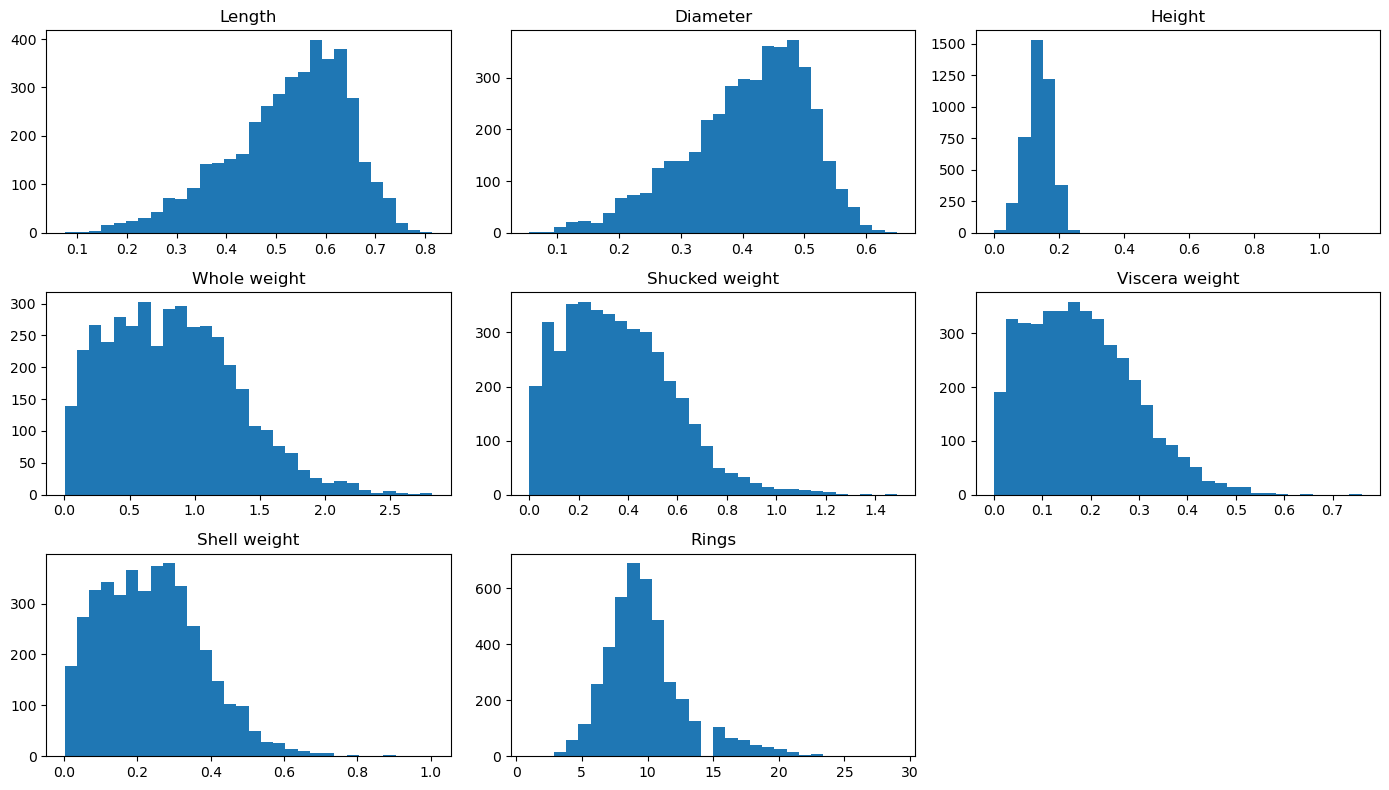

In [89]:
def hist(column):
    plt.hist(column, bins=50)
    plt.title(f'{column.name} hist')
    plt.show()

df.select_dtypes(include=[float, int]).hist(bins=30, figsize=(14,8), grid=False)
plt.tight_layout()
plt.show()
# 수치형데이터 분포 확인
# right skewed : column 4, 5, 6, 7
# left skewed : column 1, 2
# outlier 존재 : column 3
# 타겟 데이터는 약한 right skewed

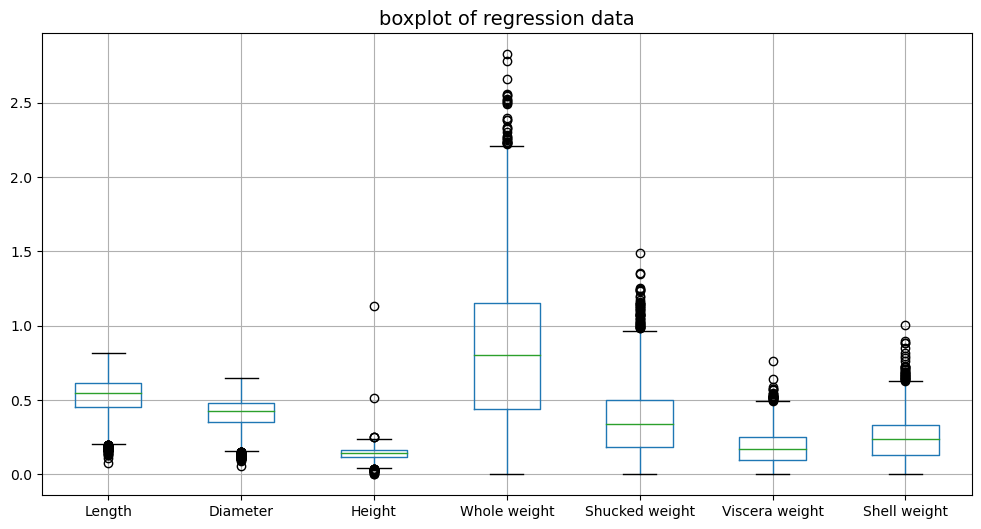

In [8]:
# boxplot
plt.figure(figsize=(12,6))
df.drop(columns='Rings').boxplot()
plt.title('boxplot of regression data', fontsize=14)
plt.show()

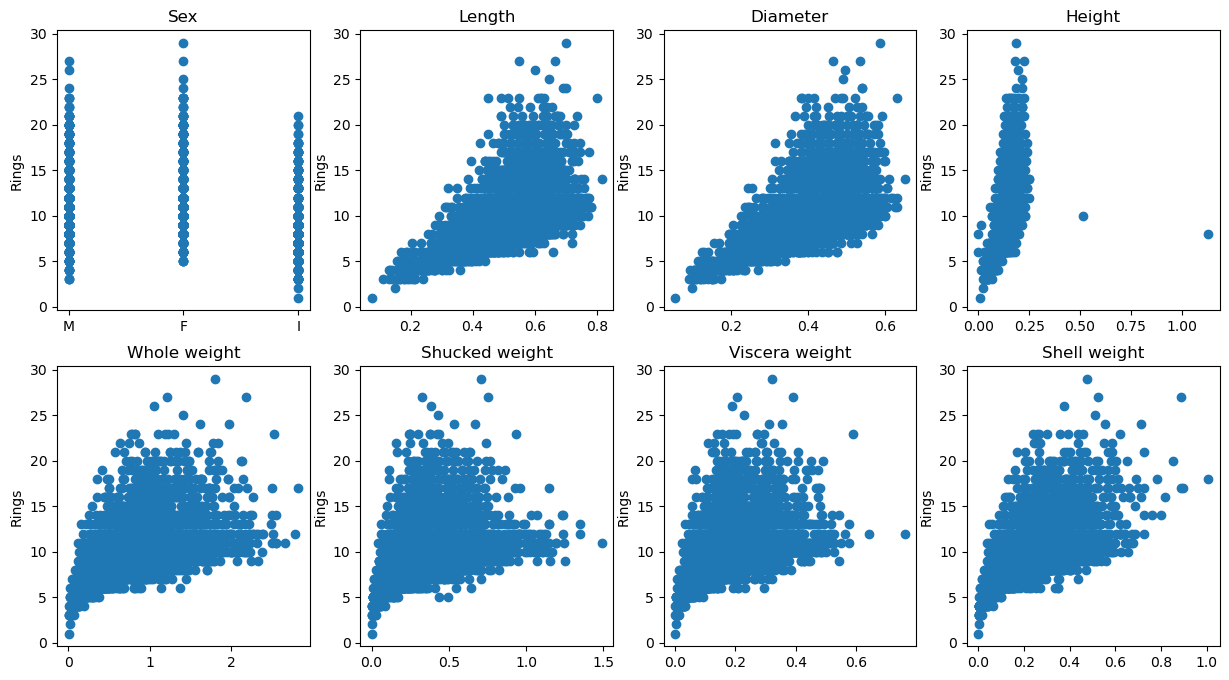

In [27]:
# 산점도
plt.subplots(2,4, figsize=(15,8))
for idx, col in enumerate(df.drop(columns='Rings').columns):
    plt.subplot(2, 4, idx+1)
    plt.scatter(df[col], df.Rings)
    plt.title(col)
    plt.ylabel('Rings')

# 분포가 다 비슷비슷하다. 독립변수들의 상관관계가 클것같다.

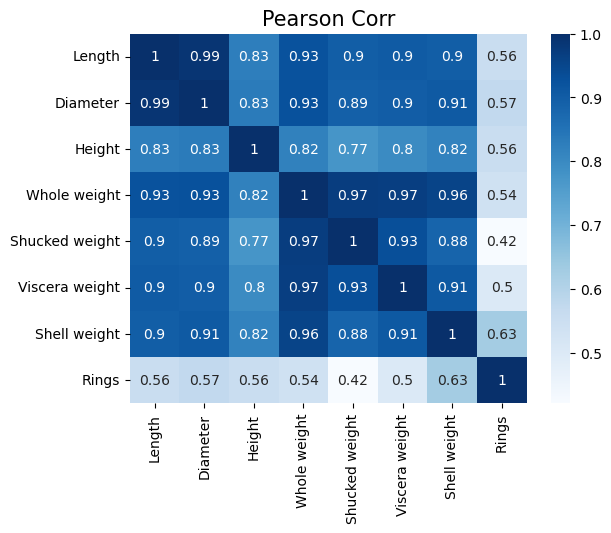

In [21]:
# column3 (Height) 아웃라이어 : 1.130, 0.515
df.Height.sort_values(ascending=False)[:5]

# 상관계수 확인
sns.heatmap(df.iloc[:,1:].corr().abs(), annot=True, cmap='Blues')
plt.title('Pearson Corr', fontsize=15)
plt.show()

# 전반적으로 컬럼들의 상관계수가 높다.
# (Length, Diameter) (Whole wieght, Shucked weight)가 상관계수 높음
# => 차원축소 고려?

In [32]:
# VIF 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False) 
sex_encoded = encoder.fit_transform(df[['Sex']])

sex_encoded_df = pd.DataFrame(sex_encoded, columns=['M','F','I'])

# 'Sex' 컬럼을 인코딩된 컬럼으로 교체
X = df.drop("Sex", axis=1)
X = pd.concat([X, sex_encoded_df], axis=1)
encoded_df = X.drop("Rings", axis=1)

# VIF를 계산하는 함수 정의
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# VIF 계산
vif_result = calculate_vif(encoded_df)

print(vif_result)
# VIF가 전제척으로 높다.

          Feature         VIF
0          Length   40.945763
1        Diameter   42.379841
2          Height    3.581369
3    Whole weight  109.768710
4  Shucked weight   28.550546
5  Viscera weight   17.445012
6    Shell weight   21.263272
7               M   23.079561
8               F   19.854572
9               I   25.751173


## data2 (Binary_classification_data)

In [ ]:
# 펄서 데이터셋 관련 정보
# https://academic.oup.com/mnras/article/409/2/619/1037409
# https://www.escholar.manchester.ac.uk/api/datastream?publicationPid=uk-ac-man-scw:305203&datastreamId=FULL-TEXT.PDF

In [35]:
df2 = pd.read_csv('data/binary_classification_data.csv')
df2.info()
print(f'\n 중복항 존재여부 : {df2.duplicated().any()}\n')
print('target class 비율')
df2.target_class.value_counts(normalize=True)

# row 17898개, 범주형 없음, 중복, 결측없음
# => catboost, LightGBM 고려 x
# target의 비율이 약 9:1로 클래스불균형 매우 심함
# => 이상탐지 모델 혹은 샘플링기법 사용 고려

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB

 중복항 

0    0.908426
1    0.091574
Name: target_class, dtype: float64

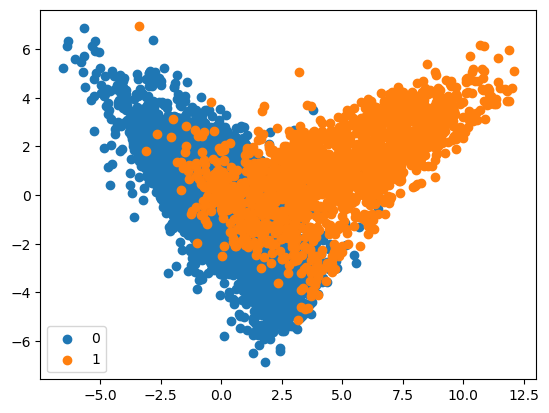

0    16259
1     1639
Name: target_class, dtype: int64

In [194]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
temp = scaler.fit_transform(df2.drop(columns='target_class'))
pca = PCA()
temp = pca.fit_transform(temp)
temp1 = pd.DataFrame(temp[:,:2], columns=['component1', 'component2'])
temp1 = pd.concat((temp1, df2[['target_class']]), axis=1)
plt.scatter(temp1[temp1.target_class==0].component1, temp1[temp1.target_class==0].component2, label='0')
plt.scatter(temp1[temp1.target_class==1].component1, temp1[temp1.target_class==1].component2, label='1')
plt.legend()
plt.show()


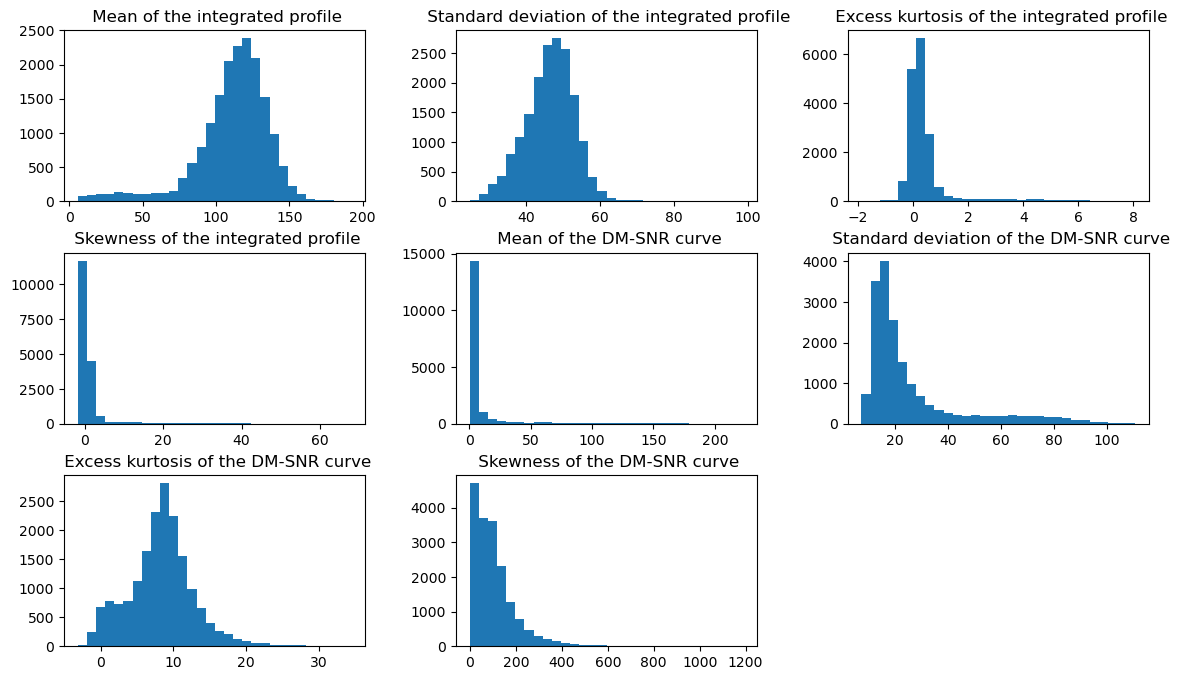

In [90]:
# 데이터 분포 확인
df2.iloc[:,:-1].hist(bins=30, figsize=(14,8), grid=False)
plt.show()

# right skewed : column 3, 4, 5, 6, 7, 8
# left skewed : column 1
# outlier 존재 : column 2, 3, 4, 5, 8
# 아웃라이어가 있는 컬럼 다수
# 전체적으로 right skewed

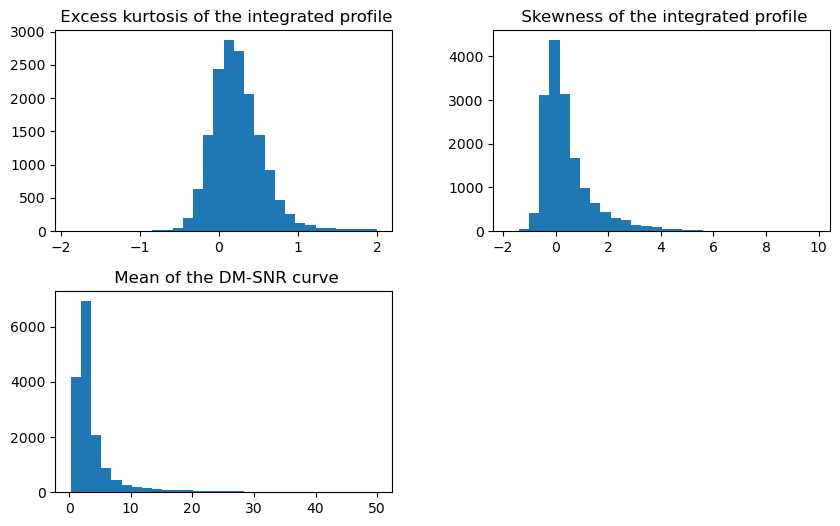

In [139]:
# 3개 컬럼 이상치 제거이후 분포확인
cols = df2.iloc[[0],[2,3,4]].columns
df2[(df2[cols[0]] < 2) & (df2[cols[1]] < 15) & (df2[cols[2]] < 50)][cols].hist(bins=30, figsize=(10,6), grid=False)
plt.show()

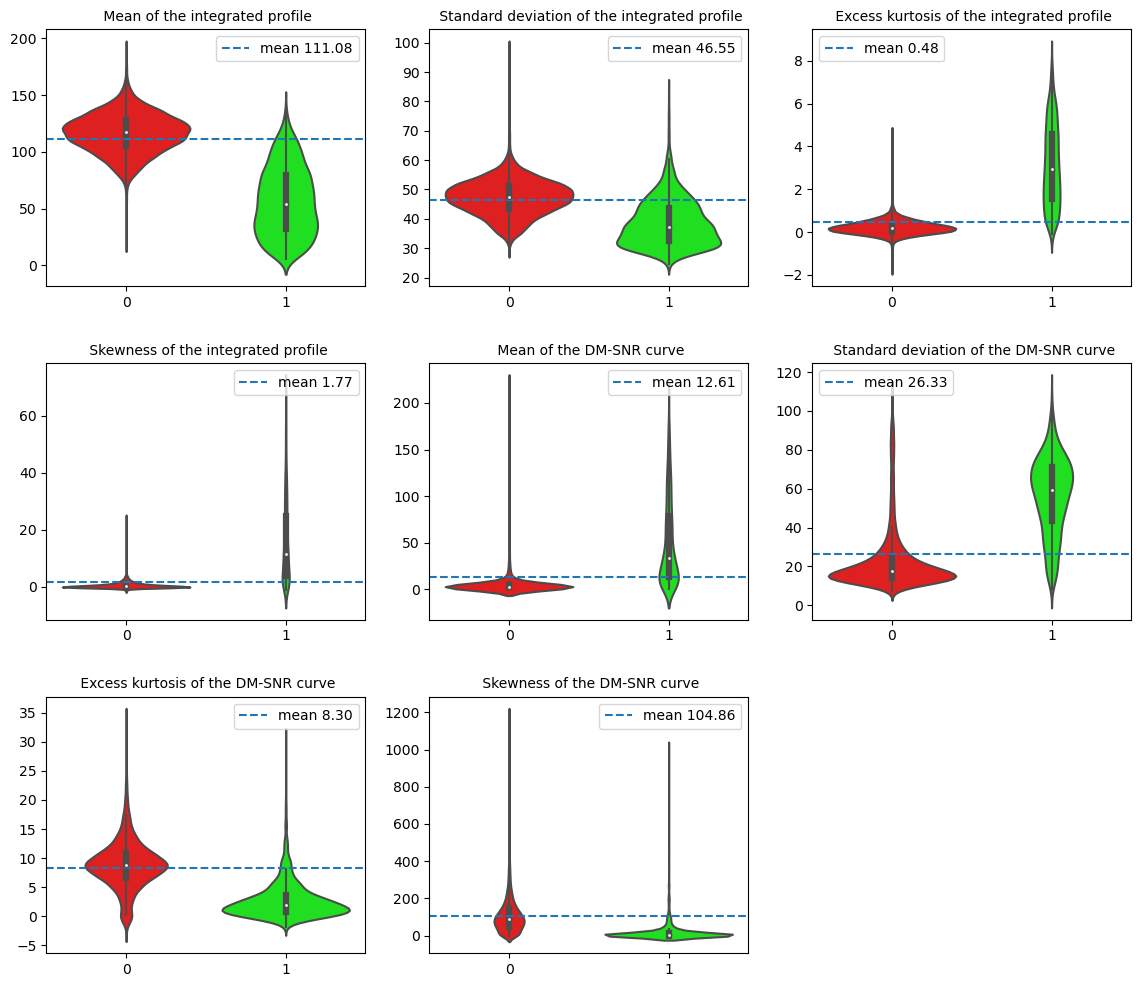

In [74]:
# 바이올린 플롯 확인
plt.figure(figsize=(14,12))
for idx, col in enumerate(df2.drop(columns='target_class')):
    plt.subplot(3,3,idx+1)
    sns.violinplot(x=df2['target_class'], y=df2[col], palette=['red', 'lime'], )
    plt.axhline(df2[col].mean(), linestyle='dashed', label=f'mean {df2[col].mean():.2f}')
    plt.ylabel('')
    plt.xlabel('')
    plt.legend(loc='best')
    plt.title(col, fontsize=10)
    
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()
# 이상치와 클래스간에 상관관계가 있는것을 확인할 수 있다.

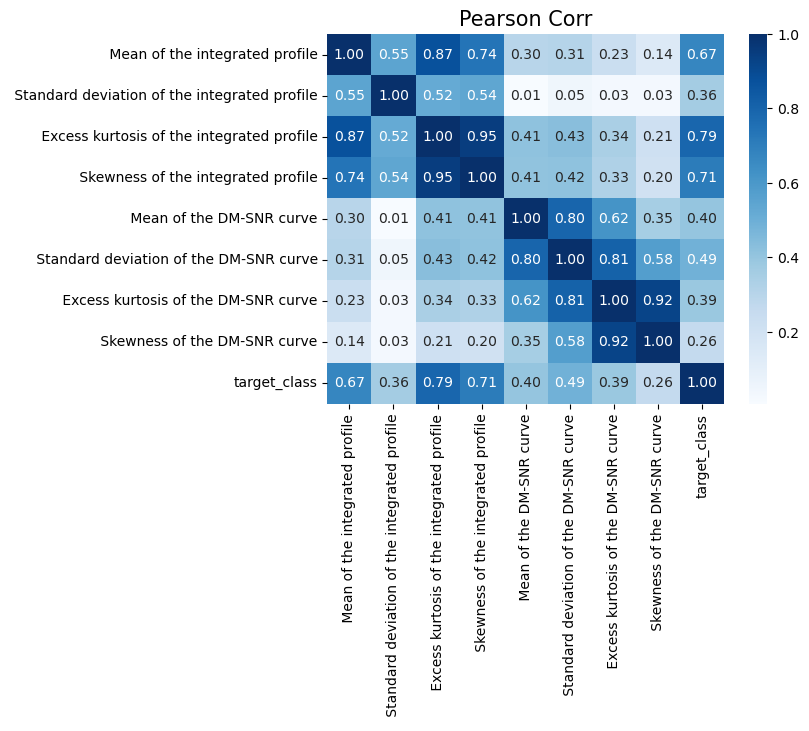

In [20]:
# 상관계수 확인
sns.heatmap(df2.corr().abs(), annot=True, cmap='Blues', fmt='.2f')
plt.title('Pearson Corr', fontsize=15)
plt.show()

# (Skewness of the integrated profile, Excess kurtosis of the integrated profile)
# (Excess kurtosis of the DM-SNR curve, Skewness of the DM-SNR curve)가 상관계수 높음
# => 상관계수가 전체적으로 높진않다. 2개 feature를 드랍하거나 아니면 무시하고 진행가능할듯?

In [171]:
# VIF를 계산하는 함수 정의
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# VIF 계산
vif_result = calculate_vif(df2)
vif_result.sort_values(by='VIF', ascending=False, inplace=True)
# vif_result.VIF = vif_result.VIF.apply(lambda x: '{:.1f}'.format(x))
display(vif_result)

,Feature,VIF
6,Excess kurtosis of the DM-SNR curve,102.860366
0,Mean of the integrated profile,98.865849
1,Standard deviation of the integrated profile,78.289884
2,Excess kurtosis of the integrated profile,33.330398
7,Skewness of the DM-SNR curve,27.844482
3,Skewness of the integrated profile,16.977036
5,Standard deviation of the DM-SNR curve,15.983135
4,Mean of the DM-SNR curve,4.235378
8,target_class,3.420868


## data3 (multi_classification_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

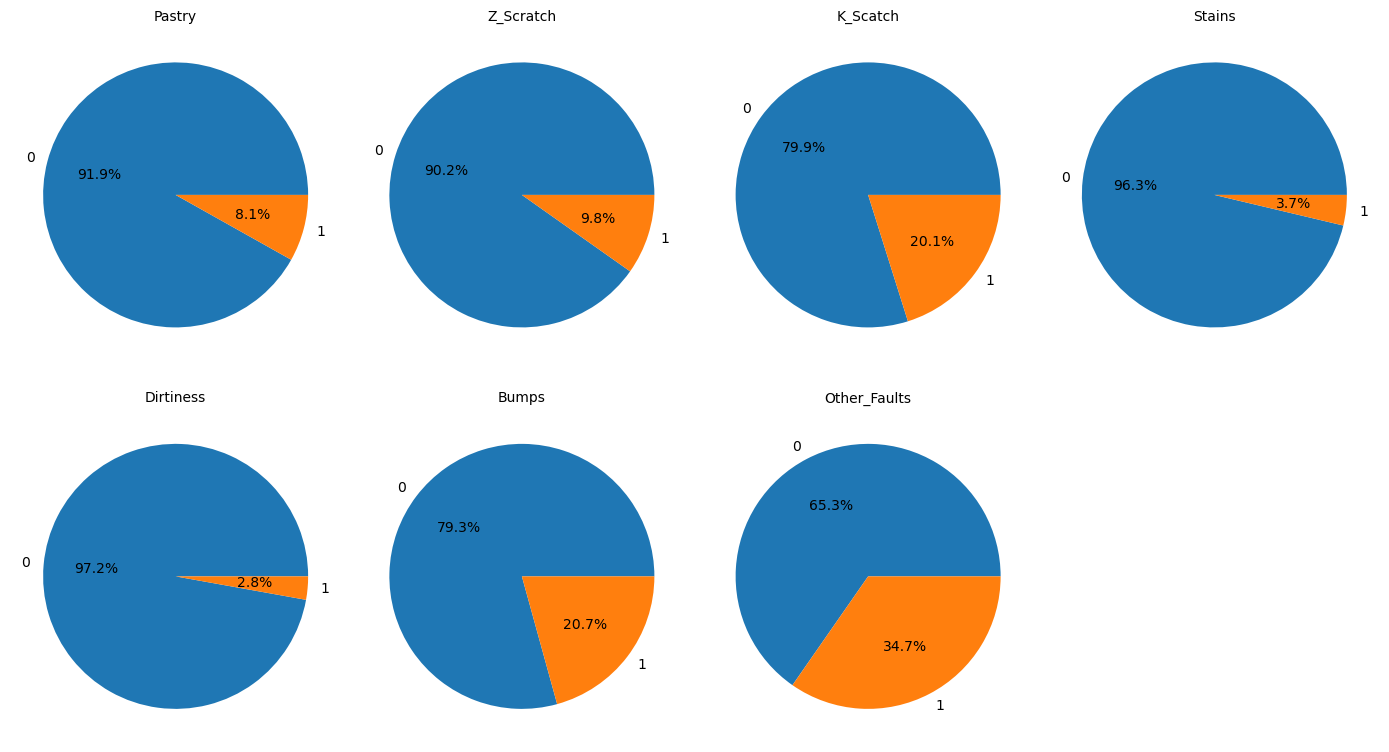

In [75]:
df3 = pd.read_csv('data/mulit_classification_data.csv')
df3.info()
print(f'\n 중복항 존재여부 : {df3.duplicated().any()}\n')

# 하자가 없는 row가 있는지 확인
print(f'하자없는 row : {df3.iloc[:,27:].apply(lambda row: not (row == 1).any(), axis=1).any()}')

print('target class 비율')
fig = plt.figure(figsize=(14,8))
x = 0
for i in df3.iloc[:,27:].columns:
    x += 1
    temp = df3[i].value_counts()
    ax = fig.add_subplot(240+x)
    ax.pie(temp, labels=[0,1], autopct='%1.1f%%')
    ax.set_title(i, fontsize=10)
plt.tight_layout()
plt.show()


# row 1941개
# 중복없음, 결측없음
# 독립변수중 범주형 3개
# target 7개이며, class 비율이 다채롭다. 2.8% 부터 34.7% 까지 존재
# 하자가 하나도 없는 row는 없다. 마찬가지로 하자는 하나씩만 존재한다.

# => 마찬가지로 Catboost, LigthGBM 고려 x
# 

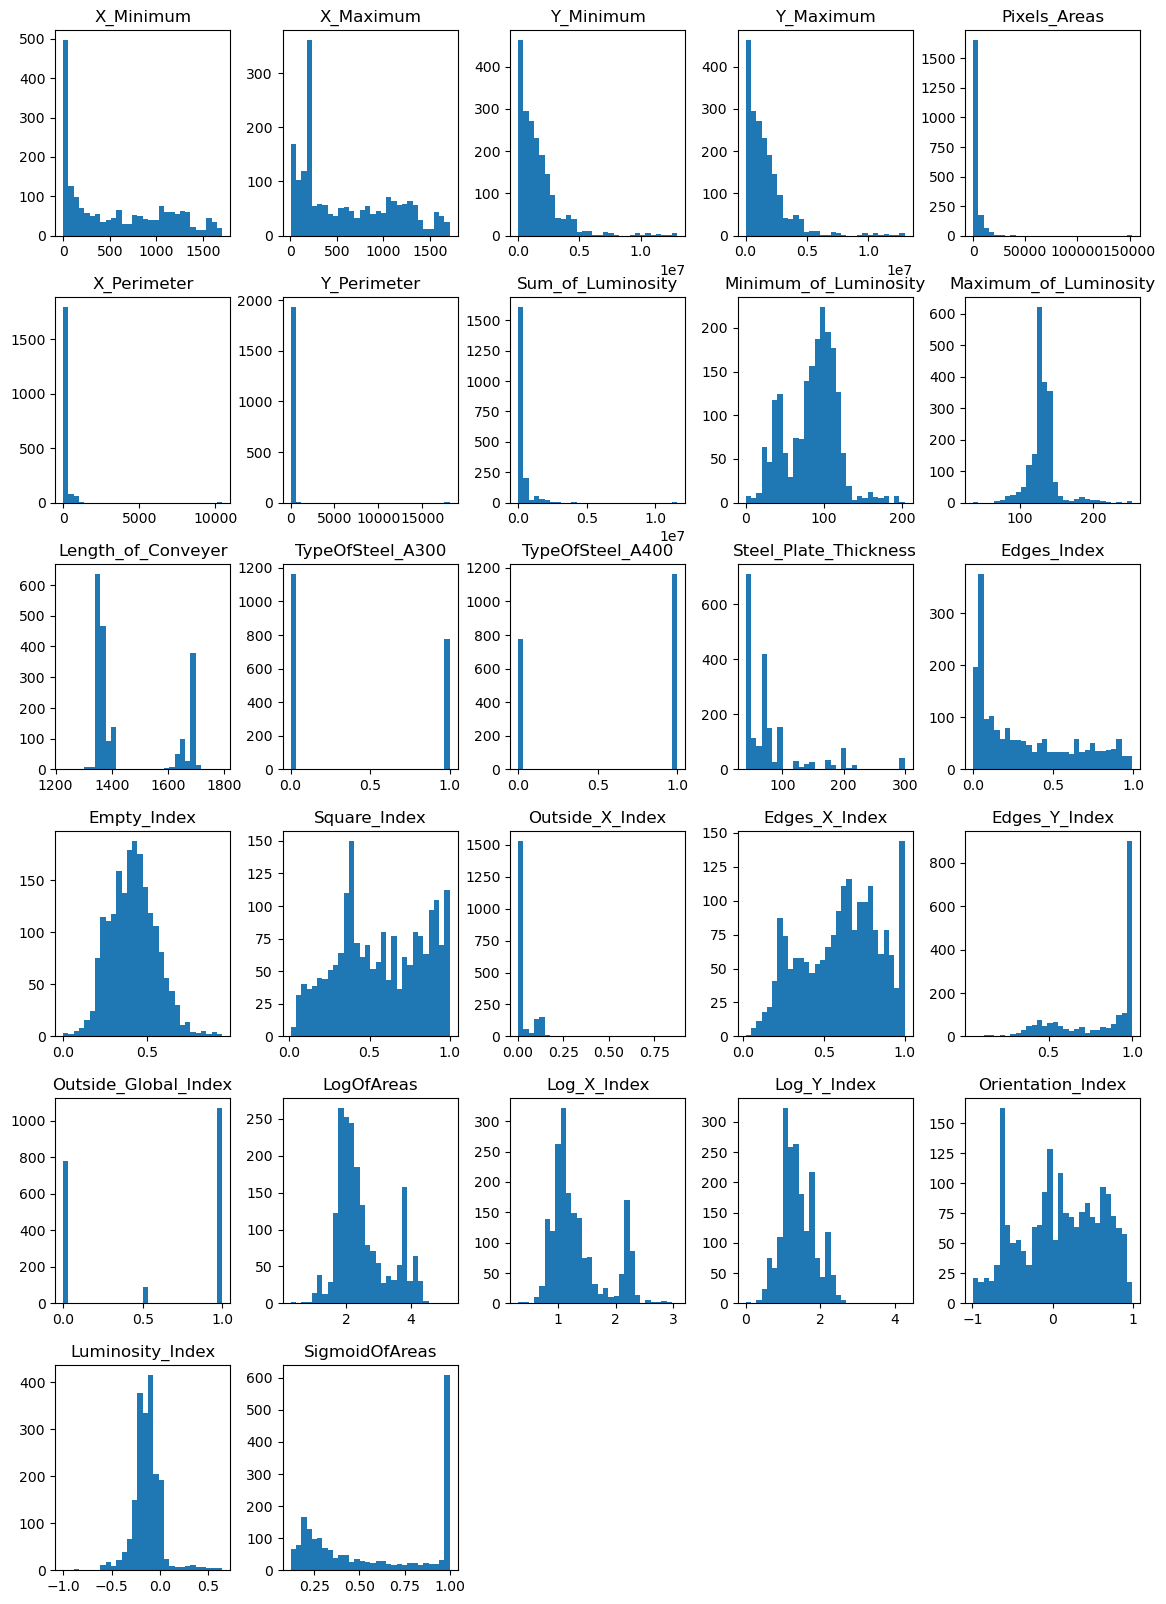

In [81]:
# 데이터 분포 확인
df3.iloc[:,:27].hist(bins=30, figsize=(14,20), grid=False)
plt.show()

# 전체적으로 skewed data가 많다.
# 범주형 데이터 : ['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index']
# Pixels_Areas, X_Perimeter, Y_Perimeter, Sum_of_Luminosity 아웃라이어 존재

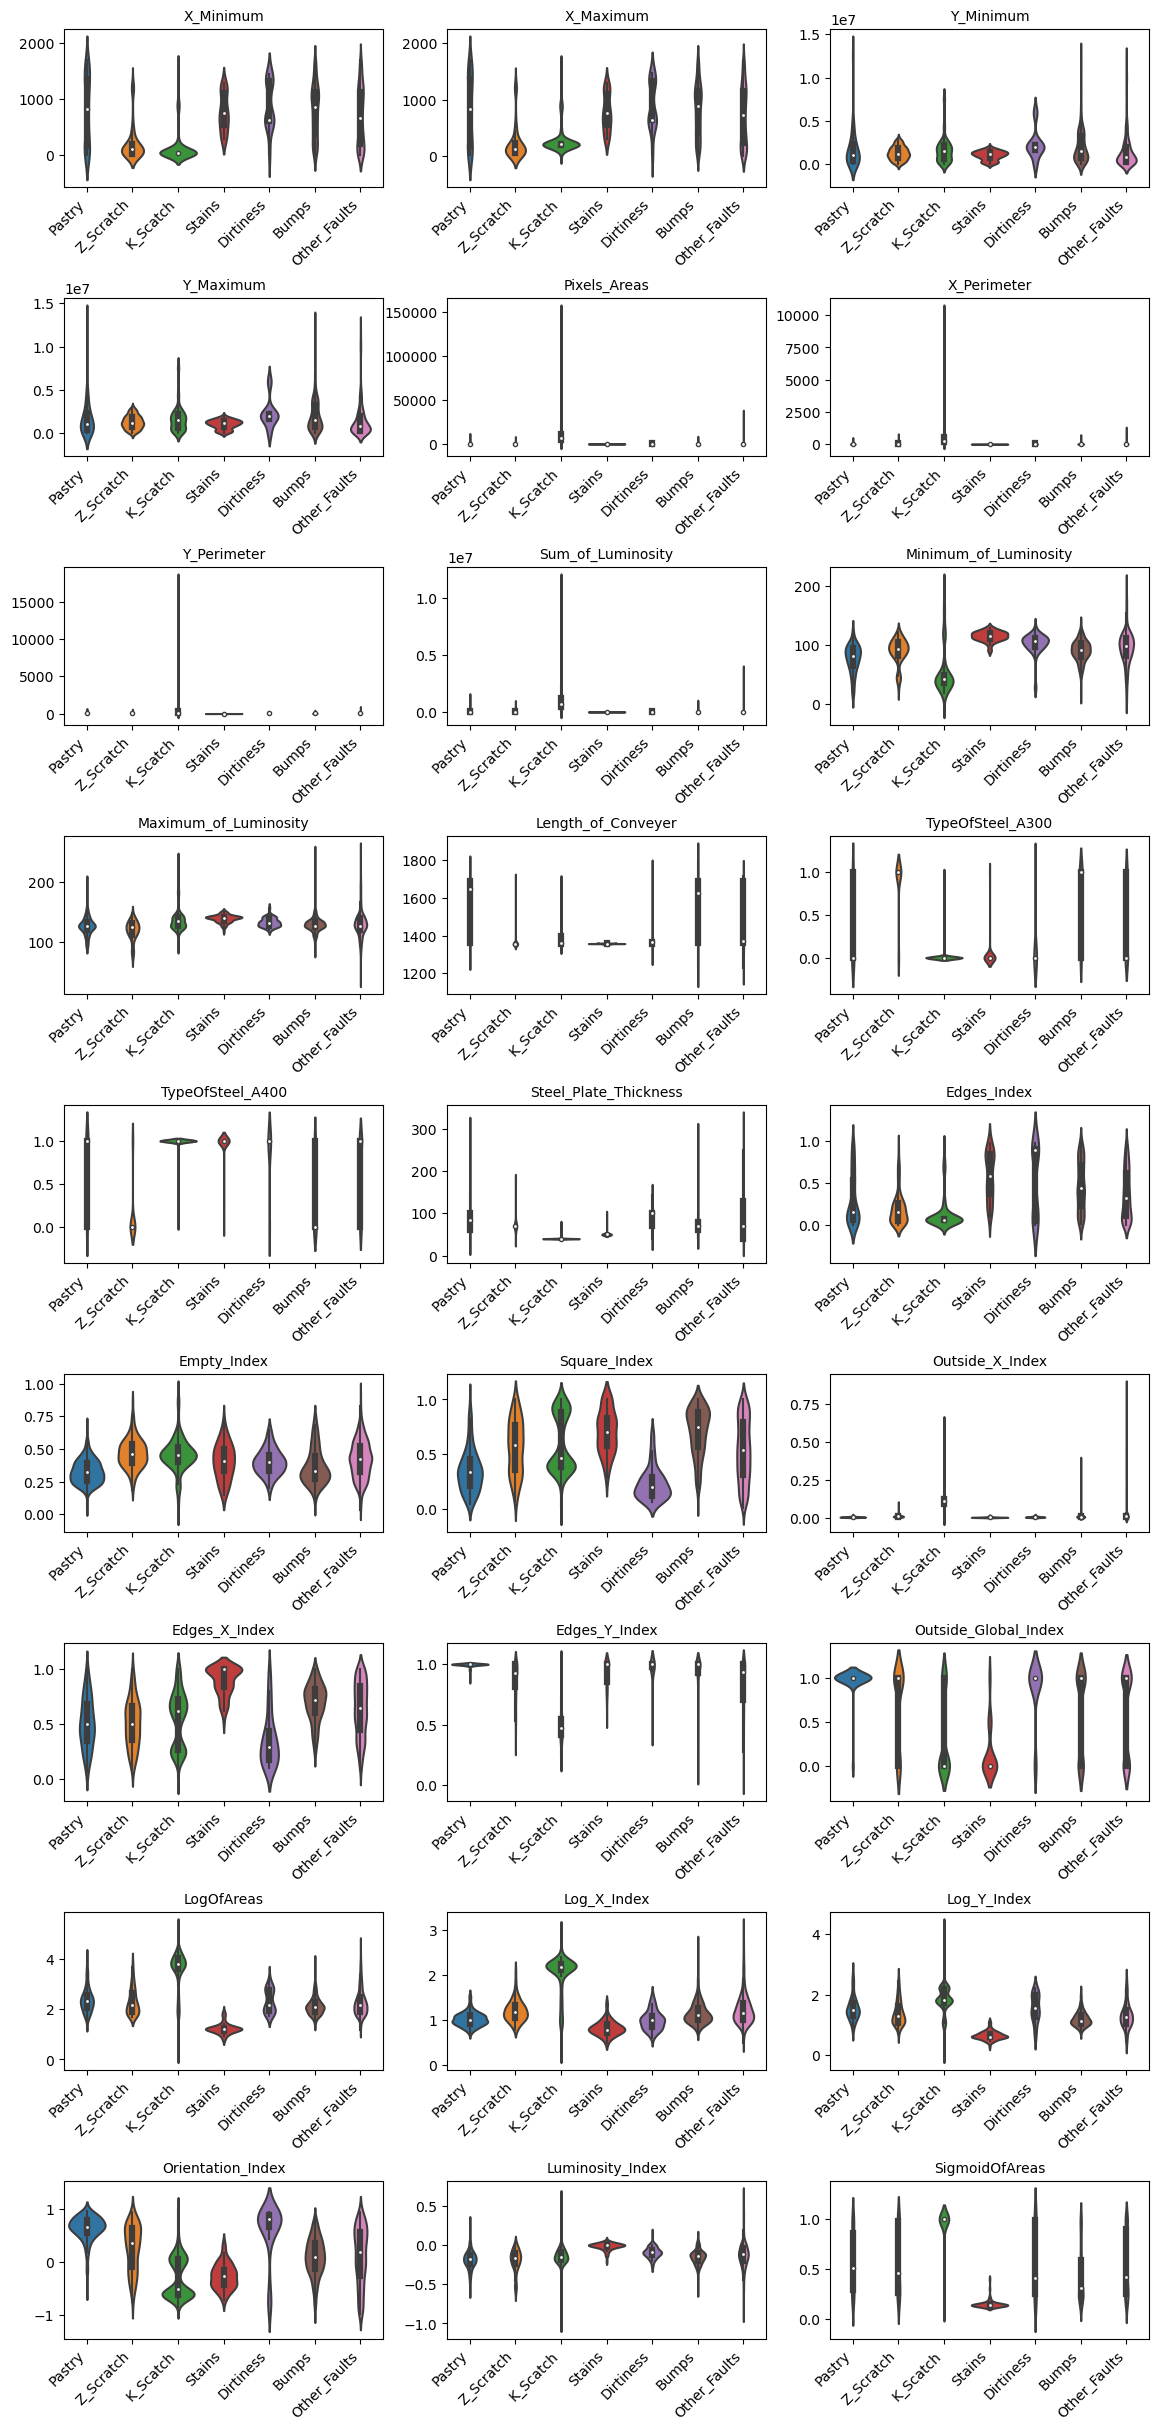

In [124]:
# 바이올린플롯 확인
targets = df3.loc[:,'Pastry':'Other_Faults']
dic = dict(zip([0,1,2,3,4,5,6], targets.columns))
temp = df3.iloc[:,:27]
temp['label'] = targets.apply(lambda x: np.argmax(x), axis=1)
temp.label = temp.label.map(dic)

plt.figure(figsize=(14,30))
for idx, col in enumerate(temp.drop(columns='label')):
    plt.subplot(9,3,idx+1)
    sns.violinplot(x=temp.label, y=temp[col])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(col, fontsize=10)
    
plt.subplots_adjust(wspace=0.2, hspace=0.7)
plt.show()
# 보기힘들다. 특정 결함은 특정 독립변수와 강하게 연관되어있다.

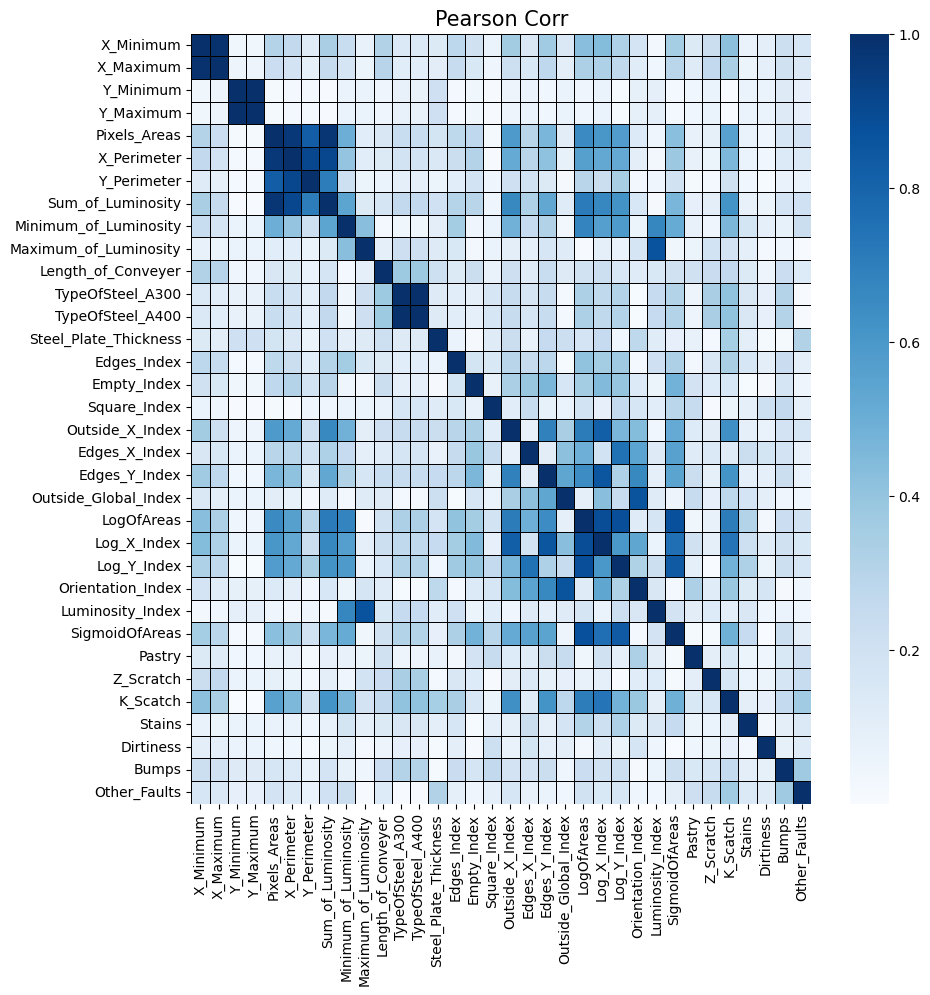

In [99]:
# 상관계수 확인
plt.figure(figsize=(10,10))
sns.heatmap(df3.corr().abs(), cmap='Blues', linewidths=0.4, linecolor='black')
plt.title('Pearson Corr', fontsize=15)
plt.show()

# X, Y의 min max는 상관계수 1
# TypeOfSteel두개는 상관계수 1
# Pixels_Areas와 Sum_of_Luminosity의 상관계수도 0.97로 매우 높다.

In [169]:
# VIF 확인
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

num_cols = df3.iloc[:,:27].drop(columns=['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index']).columns
ct = make_column_transformer(
    (StandardScaler(), num_cols),
    remainder='passthrough'
)
ct.set_output(transform='pandas')
temp = ct.fit_transform(df3.iloc[:,:27])
temp.rename(columns=lambda x: x.replace('standardscaler__', '').replace('remainder__', ''), inplace=True)

# VIF를 계산하는 함수 정의
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# VIF 계산
vif_result = calculate_vif(temp)
vif_result.sort_values(by='VIF', ascending=False, inplace=True)
vif_result.VIF = vif_result.VIF.apply(lambda x: '{:.1f}'.format(x))
display(vif_result)

# Y_Max ~ Luminosity_Index 까지 VIF가 매우 높다.

,Feature,VIF
3,Y_Maximum,17032637295.8
2,Y_Minimum,17032444045.4
0,X_Minimum,42072.5
1,X_Maximum,38413.7
6,Y_Perimeter,1559.2
18,LogOfAreas,1185.8
15,Outside_X_Index,1000.6
19,Log_X_Index,491.2
4,Pixels_Areas,490.7
20,Log_Y_Index,405.6


# EDA 내용 정리
* 3개 데이터 전부 중복, 결측치 없음

## data1 (회귀)
* row 4177개로 비교적 적음.
* Sex를 제외하곤 전부 수치형데이터
* Sex 컬럼의 카디널리티 3, 분포는 고른편
* 전반적으로 컬럼들이 약하게 skewed 되어있음
* Height 컬럼 이상치 존재
* 상관계수가 평균적으로 매우 높음. 다중공선성 문제 발생가능성 있음  

---
> 전처리 제안  
> * xgboost, random forest, 신경망중 하나 사용  
> * Sex 컬럼 원핫인코딩 혹은 타겟인코딩
> * skewed data 처리? (보통 신경망과 트리모델은 크게 필요없는편)
> * 다중공선성 해결을 위해 PCA 혹은 AE로 차원축소 고려
> * 성능은 신경망이 가장 좋을것으로 예상되나, 계산자원 많이필요 (계산시간 및 자원제한은 없음)  
     

## data2 (이진분류)
* row 17898개, 범주형 없음
* target의 비율이 약 9:1로 클래스불균형 매우 심함
* 주로 right skewed
* 이상치 있는 컬럼 3개
* 상관계수는 적당한편. 2개 세트가 연관성 있음.
* 바이올린플롯 확인결과 이상치와 타겟클래스에 연관이 있음.

---
전처리 제안
> * 왜도 조정시도
> * 이상치는 조정x (타겟과 관련있음)
> * 상관성 높은 컬럼 버려보기
> * 클래스불균형이 심하므로 이상탐지 전문모델을 쓰거나, 샘플링 기법 고민필요

## data3 (다중분류)
* row 1941개, 독립변수 27개
* 독립변수중 범주형 3개
* target 7개이며, class 비율이 다채롭다. 2.8% 부터 34.7% 까지 존재
* 하자가 하나도 없는 row는 없다. 마찬가지로 하자는 하나씩만 존재한다.  
=> softmax로 구분가능
* 데이터는 skewed 와 정규분포, 유니폼분포 모두 존재
* 상관계수는 몇개빼고 전체적으로 낮은편. 높은 몇개는 1에 매우 가깝다.
* 바이올린플롯 확인결과 특정 결함들은 특정 독립변수와 연관이 높다.

---
전처리 제안
> * 관측치 부족하고 컬럼이 많다. 차원축소 필요할듯
> * 클래스불균형이 각 결함마다 크게 다르다. 머신러닝모델론 한계 있을듯?
> * 전처리를 매우빡세게 할게 아니면 신경망 쓰는게 좋을것 같다.